### BloomTech Data Science


---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**


In [46]:
%%capture
!pip install category_encoders
!pip install pdpbox
!pip install shap

In [115]:
import pandas as pd
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import TargetPlot, InteractTargetPlot
from pdpbox import pdp
import shap
import warnings

In [48]:
pdp_isolate = PDPIsolate
pdp_plot = TargetPlot
pdp_interact = PDPInteract
pdp_interact_plot = InteractTargetPlot

In [49]:
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [50]:
pd.set_option('display.max_columns', 500)

# I. Wrangle Data

In [51]:
DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'


In [52]:
def wrangle(filepath):

  # Set issue date to index
  df = pd.read_csv(filepath, parse_dates=['issue_d'], index_col='issue_d').sort_index()

  # subset data to 36-month loans
  mask = df['term'].str.strip() == '36 months'
  df = df[mask]
  df.drop(columns='term', inplace=True)

  # Turn `'int_rate'` col into float
  df['int_rate'] = df['int_rate'].str.strip(' %').astype(float)

  # Consolidate and OHE loan purpose (`'title'`)
  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  for col in keywords:
    df[col] = (df['title'].fillna('').str.lower().str.contains(col, regex=True).astype(int))


  columns_to_keep = keywords + ['annual_inc','funded_amnt','int_rate','fico_range_high']

  df = df[columns_to_keep]

  # Rename columns
  # df.rename(columns={'annual_inc': 'annual_income',
  #                   'business': 'purpose_business',
  #                   'car|vacation|medical|moving': 'purpose_major_purchase',
  #                   'consolidation|credit': 'purpose_consolidation',
  #                   'fico_range_high': 'credit_score',
  #                   'funded_amnt': 'loan_amount',
  #                   'home': 'purpose_home_purchase',
  #                   'int_rate': 'interest_rate'}, inplace=True)
  return df

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [19]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,112323.0,NaN,3500.0,3500.0,1125.0,36 months,10.28%,113.39,C,C1,The Dartmouth Company,< 1 year,RENT,20000.0,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,I'm a working professional living in Boston. I...,moving,Renting Apartment: Need security deposit,021xx,MA,1.50,0.0,Sep-2003,680.0,684.0,0.0,0.0,0.0,17.0,0.0,1882.0,32.4%,18.0,f,0.0,0.0,4097.157701,1316.94,3500.0,582.16,15.0,0.0,0.0,Sep-2010,6.57,NaN,Jan-2019,829.0,825.0,NaN,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-01,92440.0,NaN,5000.0,5000.0,3100.0,36 months,7.43%,155.38,A,A2,MetraTech Corp,7 years,MORTGAGE,95000.0,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,I would like to make a mortgage pre-payment in...,vacation,Mortgage Pre-Payment,017xx,MA,3.83,0.0,Jul-2000,770.0,774.0,0.0,0.0,0.0,8.0,0.0,3660.0,6.8%,16.0,f,0.0,0.0,5593.631701,3468.05,5000.0,593.63,0.0,0.0,0.0,Jul-2010,157.38,NaN,Jun-2007,774.0,770.0,NaN,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN

In [20]:
df.shape

(128334, 149)

In [24]:
mask = df['term'].str.strip() == '36 months'
df[mask]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
issue_d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-01,112323.0,NaN,3500.0,3500.0,1125.0,36 months,10.28%,113.39,C,C1,The Dartmouth Company,< 1 year,RENT,20000.0,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,I'm a working professional living in Boston. I...,moving,Renting Apartment: Need security deposit,021xx,MA,1.50,0.0,Sep-2003,680.0,684.0,0.0,0.0,0.0,17.0,0.0,1882.0,32.4%,18.0,f,0.0,0.0,4097.157701,1316.94,3500.0,582.16,15.0,0.0,0.0,Sep-2010,6.57,NaN,Jan-2019,829.0,825.0,NaN,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2007-07-01,92440.0,NaN,5000.0,5000.0,3100.0,36 months,7.43%,155.38,A,A2,MetraTech Corp,7 years,MORTGAGE,95000.0,Not Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,I would like to make a mortgage pre-payment in...,vacation,Mortgage Pre-Payment,017xx,MA,3.83,0.0,Jul-2000,770.0,774.0,0.0,0.0,0.0,8.0,0.0,3660.0,6.8%,16.0,f,0.0,0.0,5593.631701,3468.05,5000.0,593.63,0.0,0.0,0.0,Jul-2010,157.38,NaN,Jun-2007,774.0,770.0,NaN,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN

In [23]:
df['term'][0]

' 36 months'

In [25]:
df['int_rate'][0]

' 10.28%'

In [26]:
df['title'].nunique()

7868

In [27]:
df['title'].value_counts().head(20)

,count
title,
Debt consolidation,62685
Credit card refinancing,25616
Home improvement,7164
Other,6170
Major purchase,2353
Debt Consolidation,1388
Medical expenses,1350
Car financing,1162
Business,949


In [53]:
df.head()

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,int_rate,fico_range_high
issue_d,,,,,,,,
2007-07-01,0,0,0,0,20000.0,3500.0,10.28,684.0
2007-07-01,0,0,0,0,95000.0,5000.0,7.43,774.0
2007-07-01,0,0,0,0,150000.0,5000.0,7.43,779.0
2007-07-01,0,0,0,0,200000.0,3000.0,10.28,679.0
2007-08-01,0,0,0,0,61800.0,4000.0,7.75,749.0


# II. Split Data

In [54]:
# Split our data in feature matrix and target vector
target = 'int_rate'
X = df.drop(columns=target)
y = df[target]


In [10]:
int(len(X) * .20)

20599

In [55]:
# Split data into training, validation, test sets
# Because this is datetime data, we'll do a cutoff
# sort_index is the key here! take tail as test data!

# numpy array slicing syntax

X_train, y_train = X[:-20_000], y[:-20_000]
X_val, y_val = X[-20_000:-10_000], y[-20_000:-10_000]
X_test, y_test = X[-10_000:], y[-10_000:]

In [56]:
X_train.shape, X_val.shape, X_test.shape

((82996, 7), (10000, 7), (10000, 7))

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82996 entries, 2007-07-01 to 2016-12-01
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   business                     82996 non-null  int64  
 1   consolidation|credit         82996 non-null  int64  
 2   home                         82996 non-null  int64  
 3   car|vacation|medical|moving  82996 non-null  int64  
 4   annual_inc                   82996 non-null  float64
 5   funded_amnt                  82996 non-null  float64
 6   fico_range_high              82996 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 5.1 MB


# III. Establish Baseline

In [58]:
print('Mean interest rate:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean interest rate: 11.559685527013349
Baseline MAE: 2.8988644656907225


# IV. Build Model

In [59]:
# not using any pipelines

model_lr = LinearRegression()
model_r = Ridge()
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

In [60]:
model_lr.fit(X_train, y_train)
model_r.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

# V. Check Metrics

In [61]:
def check_metrics(model):
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE: 2.3998605913358473
Validation MAE: 2.644777307069022
Validation R^2: 0.22254825417422563


Training MAE: 2.399861638504497
Validation MAE: 2.644770560435676
Validation R^2: 0.22255361069312118


Training MAE: 1.1495022990410637
Validation MAE: 2.7699335974071904
Validation R^2: 0.1408914858381678


Training MAE: 2.152504812594787
Validation MAE: 2.5679028082008357
Validation R^2: 0.253357898663519




# VI. Communicate Results

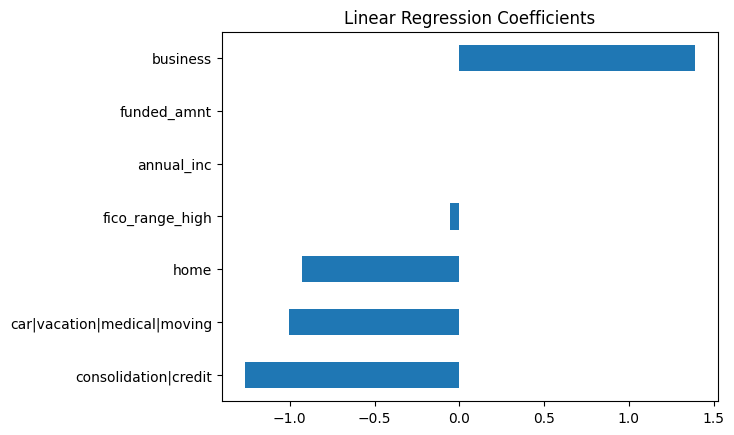

In [62]:
coefficients = model_lr.coef_
coef = pd.DataFrame(data=coefficients, index=X_train.columns, columns=['coefficients'])
coef['coefficients'].sort_values().plot(kind='barh')
plt.title('Linear Regression Coefficients')
plt.show()

In [63]:
coef

,coefficients
business,1.392802
consolidation|credit,-1.266670
home,-0.926305
car|vacation|medical|moving,-1.005387
annual_inc,-0.000004
funded_amnt,0.000019
fico_range_high,-0.054677


In [64]:
model_lr.intercept_

np.float64(51.10122488917061)

In [65]:
10000 * -0.000004

-0.04

In [ ]:
interest_rate = 51.10122 + -0.000004*annual_inc + -0.054677*fico_range_high + 0.000019*funded_amnt + -1.005387*car_vacation_medical_moving + -0.926305*home + -1.266670*consolidation_credit + 1.392802*business

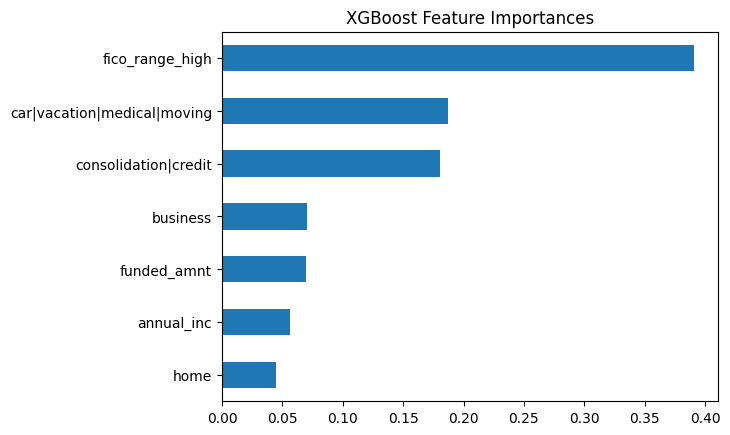

In [66]:
importances = model_xgb.feature_importances_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importances')
plt.show()

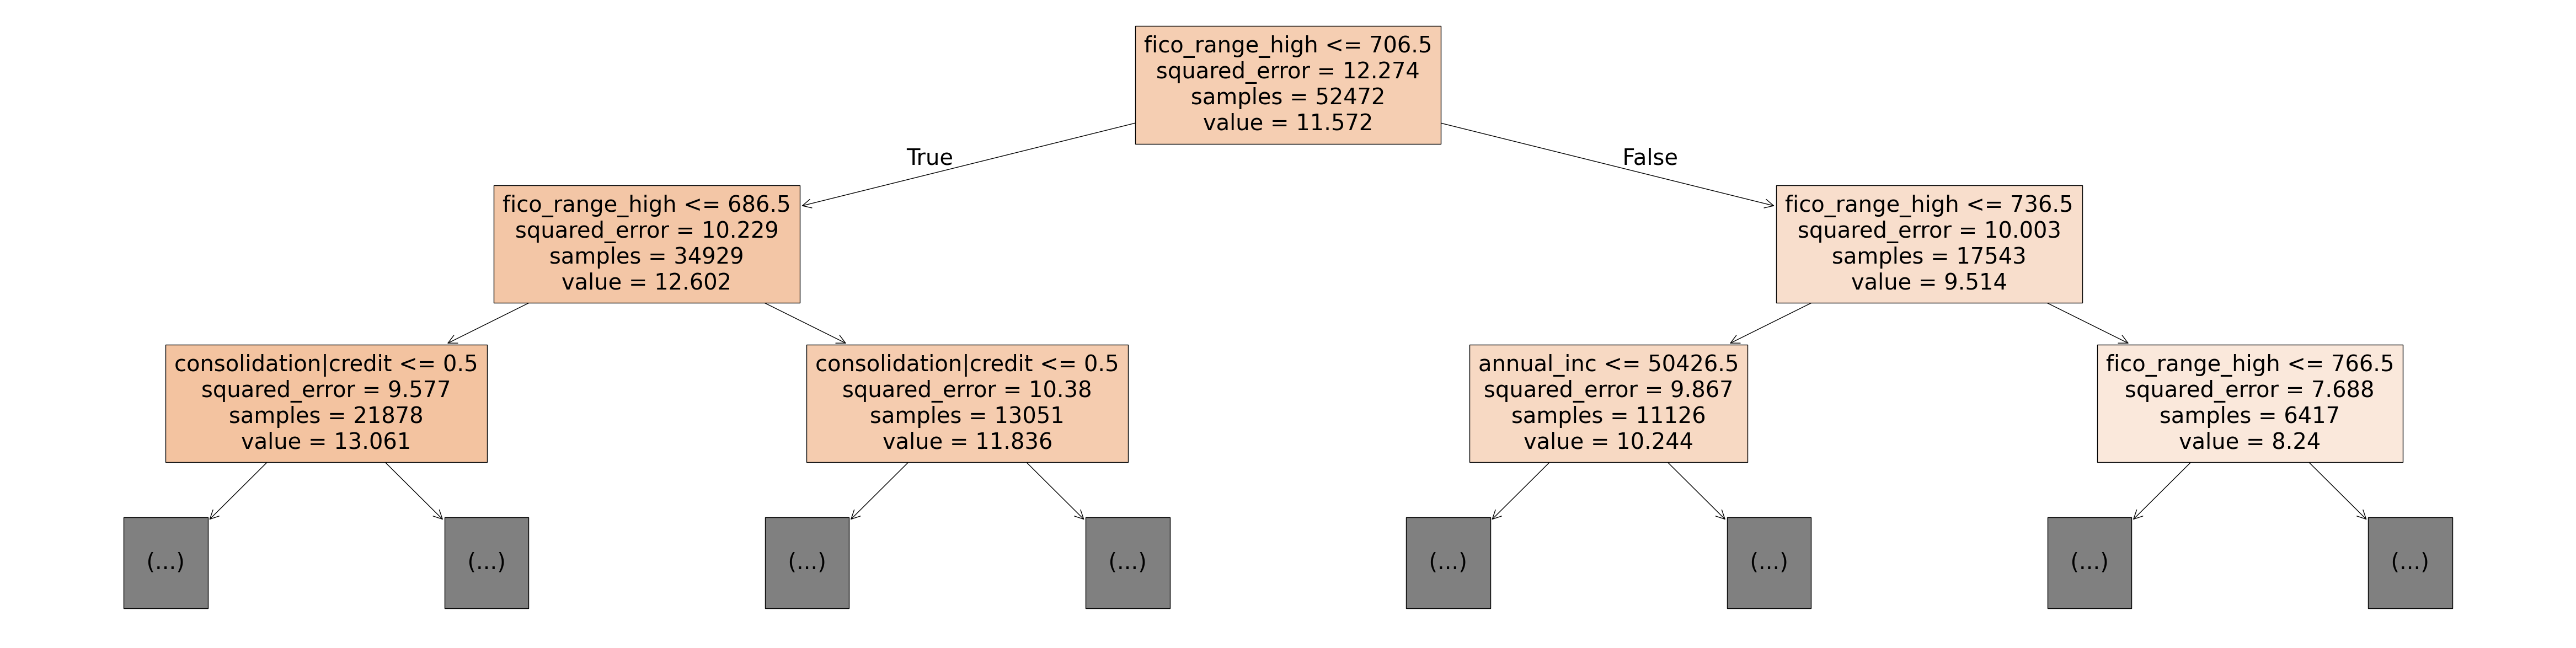

In [67]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,15))

plot_tree(
     model_rf.estimators_[0],
     max_depth=2,
     feature_names=X_train.columns,
     filled=True
);

## Partial Dependence Plots

One Feature

In [92]:
# select one feature

sample_feature = 'annual_inc'

isolate = pdp_isolate(
    model_xgb,
    df=X_val,
    model_features=X_val.columns,
    feature=sample_feature,
    feature_name=sample_feature,
    n_classes=0
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [131]:
print(X_val.shape)
X_val.head()

(10000, 8)


,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,fico_range_high,x
issue_d,,,,,,,,
2016-12-01,0,0,0,0,89000.0,4000.0,784.0,6.0
2016-12-01,0,1,0,0,56000.0,15000.0,714.0,3.0
2016-12-01,0,0,0,0,52000.0,10000.0,684.0,3.0
2016-12-01,0,1,0,0,52000.0,12000.0,689.0,3.0
2016-12-01,0,1,0,0,39000.0,6000.0,719.0,1.0


In [107]:
print(type(X_val))

<class 'pandas.core.frame.DataFrame'>


In [129]:
# create an instance of PDP Isolate.
pdp_plot(X_val, feature=sample_feature, feature_name=sample_feature, target='x')

In [84]:
pd.qcut(X['annual_inc'], q=10).value_counts()

,count
annual_inc,
"(48000.0, 55000.0]",11317
"(63000.0, 72000.0]",10683
"(32000.0, 40000.0]",10622
"(99900.0, 125000.0]",10608
"(-0.001, 32000.0]",10514
"(82500.0, 99900.0]",10262
"(40000.0, 48000.0]",10009
"(125000.0, 9300000.0]",9991
"(55000.0, 63000.0]",9512


In [130]:
# income percentile
isolate.percentile_info

AttributeError: 'PDPIsolate' object has no attribute 'percentile_info'

In [132]:
# interest rate corresponding to above percentiles
isolate.pdp

AttributeError: 'PDPIsolate' object has no attribute 'pdp'

Two features

In [136]:
# select two features

sample_two_features = ['annual_inc', 'fico_range_high']

interact = pdp_interact(
    model_xgb,
    df=X_val,
    model_features=X_val.columns,
    features=sample_two_features,
    feature_names=sample_two_features,
    n_classes = 0
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

In [142]:
X_val.drop(columns='x', inplace=True)

In [137]:
X_val.head()

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,fico_range_high,x
issue_d,,,,,,,,
2016-12-01,0,0,0,0,89000.0,4000.0,784.0,8.0
2016-12-01,0,1,0,0,56000.0,15000.0,714.0,6.0
2016-12-01,0,0,0,0,52000.0,10000.0,684.0,3.0
2016-12-01,0,1,0,0,52000.0,12000.0,689.0,4.0
2016-12-01,0,1,0,0,39000.0,6000.0,719.0,6.0


In [141]:
pdp_interact_plot(X_val, features=sample_two_features, feature_names=sample_two_features, target='x')

KeyError: "Column(s) ['x'] do not exist"

In [ ]:
# create an instance of PDP Interact.


## Shapley Plots

In [90]:
#select one sample/observation

sample_row = X_val.tail(1)

In [91]:
sample_row

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,fico_range_high
issue_d,,,,,,,
2017-08-01,0,1,0,0,38000.0,7000.0,739.0


In [143]:
# Shapley Force Plot
# This may not work well in local notebooks
# you may need to install ipywidgets

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(sample_row)

#initialization of java script
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=sample_row
)
